# Physiological Sensor Data Analysis with Tree-Based Classification

## Project Overview

This project involves developing a classification model based on physiological sensor data collected from smartphone-based sensors. The objective is to predict the activity being performed by the test subjects based on limited features. This project uses tree-based classification methods and follows a comprehensive approach to data preparation, model training, and evaluation.

## 1. Data Import and Preparation

First, we import the necessary packages and read the sensor data file from the 'assets/' folder. We also reassign activity labels as instructed.

In [1]:
# Suppress all warnings only when absolutely necessary
import warnings
warnings.filterwarnings('ignore')

# useful python standard libraries
import itertools
import math
import random

import matplotlib.pyplot as plt

# import core libraries
import numpy as np
import pandas as pd

# helpful SciKit-Learn libraries
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# path/filename to dataset
sensor_data = r'C:/users/akama/downloads/physiological_sensor_data_analysis/sensor_data.csv'

# We will use this variable name multiple times
base_feature_selector = "_mad_"

# If you need such a value
random_state = 42

np.set_printoptions(precision=4)

# Import CSV Sensor Data file
def get_sensor_data():
    df = pd.read_csv(sensor_data)
    df = df.replace({'neutral':1, 'emotional': 2, 'mental': 3, 'physical':4})
    return df

# Load and display the first few rows of the dataset
df = get_sensor_data()
df.head()

,Subject_ID,Activity_Label,ECG_original_mean_1,ECG_original_std_2,ECG_original_trimmean25_3,ECG_original_median_4,ECG_original_skewness_5,ECG_original_kurtosis_6,ECG_original_max_7,ECG_original_min_8,...,EDA_Functionals_power_Filt2skewness_524,EDA_Functionals_power_Filt2kurtosis_525,EDA_Functionals_power_Filt2max_526,EDA_Functionals_power_Filt2min_527,EDA_Functionals_power_Filt2prctile25_528,EDA_Functionals_power_Filt2prctile75_529,EDA_Functionals_power_Filt2geomean(abs)_530,EDA_Functionals_power_Filt2harmmean_531,EDA_Functionals_power_Filt2mad_532,EDA_Functionals_power_Filt2baseline_533
0,QNNG,1,-0.004125,0.254095,0.001426,-0.01037,-0.538509,5.95534,1.04063,-1.37437,...,31.4249,1015.36,717032000.0,0.027384,2.53425,17.3882,8.05589,1.80247,1413310.0,3028080.0
1,QNNG,1,0.031029,0.193761,0.012918,-0.00237,0.781415,5.18794,0.98963,-0.71937,...,31.4354,1015.78,705854000.0,0.016947,2.51513,16.5914,7.81769,1.52349,1390180.0,3016420.0
2,QNNG,1,0.015678,0.182336,-0.003028,-0.02337,0.881194,5.66530,0.87563,-0.71937,...,31.4480,1016.16,627018000.0,0.008129,2.25959,15.2312,7.11684,1.25860,1234110.0,3004430.0
3,QNNG,1,0.014525,0.176636,-0.006161,-0.02737,1.024900,6.10968,0.91063,-0.71937,...,31.4333,1015.61,559748000.0,0.007377,2.13924,14.4663,6.70236,1.26643,1102720.0,2992170.0
4,QNNG,1,0.010349,0.179248,-0.008526,-0.02737,0.935697,5.83902,0.91063,-0.75637,...,31.4346,1015.67,484473000.0,0.011448,1.93595,12.5493,6.08647,1.22387,954322.0,2979610.0


## 2. Standard Train-Test Split

We produce a standard train-test split of the sensor data using train_test_split.

In [2]:
def std_train_test_split(df, test_size=0.2, random_state=42):
    X = df.drop(columns=['Subject_ID', 'Activity_Label'])
    y = df['Activity_Label']
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

# Perform standard train-test split
X_train, X_test, y_train, y_test = std_train_test_split(df)

## 3. Baseline Tree Model

We build a baseline Decision Tree model based on the extracted features.

In [4]:
def baseline_model(tts, random_state=42):
    df = get_sensor_data()
    X_train, X_test, y_train, y_test = tts(df, test_size=0.2, random_state=random_state)
    features = [feature for feature in X_train.columns if base_feature_selector in feature]
    clf = DecisionTreeClassifier(random_state=random_state)
    clf.fit(X_train[features], y_train)
    score = clf.score(X_test[features], y_test)
    return features, score

# Evaluate the baseline model
baseline_features, baseline_score = baseline_model(std_train_test_split)
print("Baseline model features:", baseline_features)
print("Baseline model score:", baseline_score)

Baseline model features: ['ECG_original_mad_13', 'ECG_RR_window_mad_27', 'ECG_amplitude_RR_mad_41', 'ECG_HR_min_div_mad_55', 'ECG_hrv_mad_79', 'ECG_PSD_mad_93', 'ECG_p_VFL_mad_107', 'ECG_p_LF_mad_121', 'ECG_p_MF_mad_135', 'ECG_p_HF_mad_149', 'ECG_p_total_LF_mad_163', 'IT_Original_mad_187', 'IT_LF_mad_202', 'IT_RF_mad_217', 'IT_BRV_mad_233', 'IT_PSD_mad_247', 'IT_VLF_mad_261', 'IT_LF_mad_275', 'IT_MF_mad_289', 'IT_HF_mad_303', 'IT_p_Total_mad_317', 'EDA_Original_mad_338', 'EDA_processed_mad_352', 'EDA_Filt1_mad_366', 'EDA_Filt2_mad_380', 'EDA_Original_mad_442', 'EDA_processed_mad_456', 'EDA_Filt1_mad_470', 'EDA_Filt2_mad_484']
Baseline model score: 0.8158482142857143


## 4. Baseline Tree Model Evaluation

The default accuracy of ~0.816 seems reasonable given the context of the experiment. The model can accurately make predictions 81.6% of the time. However, this could be due to overfitting as decision trees often require an ensemble of trees for improved generalization performance. Another issue could be class imbalance, which may lead the model to favor the majority class, resulting in an inflated accuracy score.

## 5. Custom Train-Test Split

Due to the nature of the experiment's data collection, a custom train-test split function is implemented to avoid data leakage.

In [5]:
def custom_train_test_split(df, test_size=0.2, random_state=42):
    rng = np.random.default_rng(seed=random_state)
    unique_subjects = df['Subject_ID'].unique()
    test_subject_count = math.ceil(test_size * len(unique_subjects)) if isinstance(test_size, float) else test_size
    test_subjects = rng.choice(unique_subjects, size=test_subject_count, replace=False)
    test_data = df[df['Subject_ID'].isin(test_subjects)]
    train_data = df[~df['Subject_ID'].isin(test_subjects)]
    X_train = train_data.drop(columns=["Activity_Label"])
    y_train = train_data['Activity_Label']
    X_test = test_data.drop(columns=["Activity_Label"])
    y_test = test_data['Activity_Label']
    
    return X_train, X_test, y_train, y_test

# Perform custom train-test split and evaluate baseline model
custom_baseline_features, custom_baseline_score = baseline_model(custom_train_test_split)
print("Custom train-test split model features:", custom_baseline_features)
print("Custom train-test split model score:", custom_baseline_score)

Custom train-test split model features: ['ECG_original_mad_13', 'ECG_RR_window_mad_27', 'ECG_amplitude_RR_mad_41', 'ECG_HR_min_div_mad_55', 'ECG_hrv_mad_79', 'ECG_PSD_mad_93', 'ECG_p_VFL_mad_107', 'ECG_p_LF_mad_121', 'ECG_p_MF_mad_135', 'ECG_p_HF_mad_149', 'ECG_p_total_LF_mad_163', 'IT_Original_mad_187', 'IT_LF_mad_202', 'IT_RF_mad_217', 'IT_BRV_mad_233', 'IT_PSD_mad_247', 'IT_VLF_mad_261', 'IT_LF_mad_275', 'IT_MF_mad_289', 'IT_HF_mad_303', 'IT_p_Total_mad_317', 'EDA_Original_mad_338', 'EDA_processed_mad_352', 'EDA_Filt1_mad_366', 'EDA_Filt2_mad_380', 'EDA_Original_mad_442', 'EDA_processed_mad_456', 'EDA_Filt1_mad_470', 'EDA_Filt2_mad_484']
Custom train-test split model score: 0.5714285714285714


## 6. Multiclass Confusion Matrix

Creating a confusion matrix using Logistic Regression to better understand model performance.

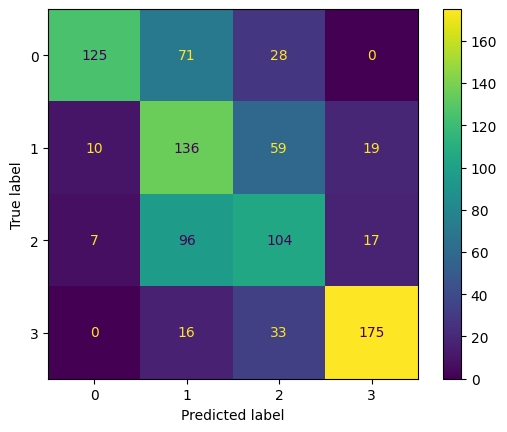

In [6]:
def LR_confusion_matrix():
    df = get_sensor_data()
    X_train, X_test, y_train, y_test = custom_train_test_split(df)
    features = [feature for feature in X_train.columns if base_feature_selector in feature]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[features])
    X_test_scaled = scaler.transform(X_test[features])
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X_train_scaled, y_train)
    y_pred = lr.predict(X_test_scaled)
    return confusion_matrix(y_test, y_pred)

# Generate and display the confusion matrix
cm = LR_confusion_matrix()
ConfusionMatrixDisplay(cm).plot()
plt.show()

## 7. Feature Importance

Using RandomForestClassifier to determine feature importance and evaluate model performance.

In [7]:
def get_top_features(top=10):
    df = get_sensor_data()
    X_train, X_test, y_train, y_test = std_train_test_split(df)
    features = [feature for feature in X_train.columns if base_feature_selector in feature]
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[features])
    X_test_scaled = scaler.transform(X_test[features])
    clf = RandomForestClassifier(random_state=42, n_jobs=-1)
    clf.fit(X_train_scaled, y_train)
    importances = clf.feature_importances_
    feature_importances = sorted(zip(features, importances), key=lambda x: x[1], reverse=True)[:top]
    return feature_importances, clf.score(X_test_scaled, y_test)

# Get and display top features
top_features, rf_score = get_top_features()
print("Top features:", top_features)
print("Random Forest model score:", rf_score)

Top features: [('IT_LF_mad_202', 0.10701968505017323), ('IT_Original_mad_187', 0.1053599684203407), ('IT_RF_mad_217', 0.06735530306392977), ('ECG_original_mad_13', 0.06012059835143219), ('ECG_amplitude_RR_mad_41', 0.056911965106362566), ('IT_p_Total_mad_317', 0.044975099376456155), ('EDA_processed_mad_456', 0.044660947909465544), ('IT_PSD_mad_247', 0.039733451499217524), ('ECG_HR_min_div_mad_55', 0.03962741286853493), ('ECG_RR_window_mad_27', 0.03835362416507629)]
Random Forest model score: 0.8783482142857143


## 8. Final Project: Optimized Model

Creating the best possible model using a limited number of features and optimizing for ROC-AUC score.

In [9]:
def activity_model(random_state=42):
    df = get_sensor_data()
    X_train, X_test, y_train, y_test = custom_train_test_split(df, test_size=0.2, random_state=random_state)
    top_features, _ = get_top_features(10)
    selected_features = [name for name, _ in top_features]
    model = GradientBoostingClassifier(random_state=random_state)
    model.fit(X_train[selected_features], y_train)
    y_pred = model.predict_proba(X_test[selected_features])
    score = roc_auc_score(y_test, y_pred, average='macro', multi_class='ovr')
    return model, selected_features, score

# Evaluate the final optimized model
final_model, final_features, final_score = activity_model()
print("Final model:", final_model)
print("Selected features:", final_features)
print("Final ROC-AUC score:", final_score)

Final model: GradientBoostingClassifier(random_state=42)
Selected features: ['IT_LF_mad_202', 'IT_Original_mad_187', 'IT_RF_mad_217', 'ECG_original_mad_13', 'ECG_amplitude_RR_mad_41', 'IT_p_Total_mad_317', 'EDA_processed_mad_456', 'IT_PSD_mad_247', 'ECG_HR_min_div_mad_55', 'ECG_RR_window_mad_27']
Final ROC-AUC score: 0.8581841916454082
